<a href="https://colab.research.google.com/github/Lavanyakapoor/Customer_Churn_prediction_Machine_Learning/blob/main/Customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install xgboost -q

In [2]:
import pandas as pd
# For data manipulation and DataFrames
import numpy as np
 # For numerical operations
import matplotlib.pyplot as plt
# For plotting
import seaborn as sns
# For enhanced visualizations
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
 # For splitting data, cross-validation, and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder, StandardScaler
# For encoding categorical data and scaling numerical features
from sklearn.pipeline import Pipeline
# For chaining preprocessing and modeling steps
from sklearn.linear_model import LogisticRegression
# Logistic Regression model
from sklearn.tree import DecisionTreeClassifier
 # Decision Tree model
from sklearn.ensemble import RandomForestClassifier
# Random Forest model
from xgboost import XGBClassifier  # XGBoost model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# For model evaluation
from scipy.stats import ttest_rel
# For statistical comparison of models
import joblib
 # For saving the model
from google.colab import files, drive
 # For file handling in Colab
import warnings
warnings.filterwarnings('ignore')
# Suppresses warnings for cleaner output


In [4]:
plt.style.use('ggplot')
sns.set(style="darkgrid", palette="deep")

In [6]:
data = pd.read_csv('Tel_Customer_Churn_Dataset.csv')

In [7]:
drive.mount('/content/drive')
output_dir = '/content/drive/My Drive/Churn_Prediction_Output/'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Mounted at /content/drive


=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling 

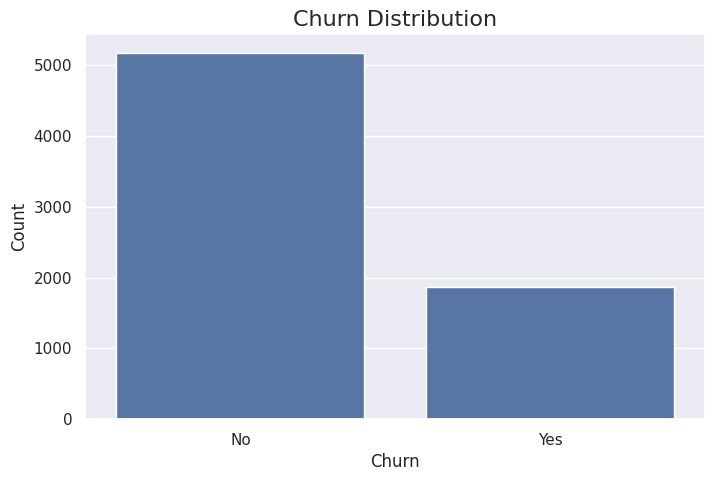

In [8]:
def perform_eda(df):
    print("=== Dataset Overview ===")
    print(df.info())  # Data types, non-null counts
    print("\n=== First 5 Rows ===")
    print(df.head())
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    print("\n=== Summary Statistics ===")
    print(df.describe())

    # Visualize churn distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Churn', data=df)
    plt.title('Churn Distribution', fontsize=16)
    plt.xlabel('Churn', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.savefig(output_dir + 'churn_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

perform_eda(data)

In [9]:
def clean_data(df):
    df = df.replace({'No internet service': 'No', 'No phone service': 'No'})
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
    df = df.drop(columns=['customerID'])
    return df

data = clean_data(data)

In [10]:
def preprocess_data(df):
    """Preprocess the dataset: encode categorical variables and split features/target."""
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    X = df.drop(columns=['Churn'])
    y = df['Churn']
    return X, y

X, y = preprocess_data(data)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [13]:
results = {}
cv_scores = {}

for name, model in models.items():
    pipeline = create_pipeline(model)

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[name] = scores

    # Training the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_test, y_pred, output_dict=True),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"\n=== {name} ===")
    print(f"Cross-Validation Accuracy: {scores.mean():.4f} (± {scores.std():.4f})")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Logistic Regression ===
Cross-Validation Accuracy: 0.8035 (± 0.0142)
Test Accuracy: 0.7999
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[921 114]
 [168 206]]

=== Decision Tree ===
Cross-Validation Accuracy: 0.7283 (± 0.0095)
Test Accuracy: 0.7218
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1035
           1       0.48      0.50      0.49       374

    accuracy                           0.72      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.72      0.72      1409

Confusion Matrix:
[[831 204]
 [188 186]]

=== Random Forest ===
Cross-Val

In [14]:
rf_pipeline = create_pipeline(RandomForestClassifier(random_state=42))
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

In [16]:
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [17]:
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred_rf)
results['Tuned Random Forest'] = {
    'Accuracy': best_rf_accuracy,
    'Classification Report': classification_report(y_test, y_pred_rf, output_dict=True),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_rf)
}

print("\n=== Tuned Random Forest ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {best_rf_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


=== Tuned Random Forest ===
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Test Accuracy: 0.8041
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion Matrix:
[[935 100]
 [176 198]]


In [18]:
joblib.dump(best_rf, output_dir + 'best_rf_model.pkl')
print(f"\nBest Random Forest model saved to {output_dir}best_rf_model.pkl")


Best Random Forest model saved to /content/drive/My Drive/Churn_Prediction_Output/best_rf_model.pkl


In [19]:
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
xgb_cv_scores = cv_scores['XGBoost']
t_stat, p_value = ttest_rel(rf_cv_scores, xgb_cv_scores)
print(f"\nStatistical Comparison (Tuned RF vs XGBoost):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Difference is statistically significant (p < 0.05).")


Statistical Comparison (Tuned RF vs XGBoost):
T-statistic: 7.7932, P-value: 0.0015
Difference is statistically significant (p < 0.05).


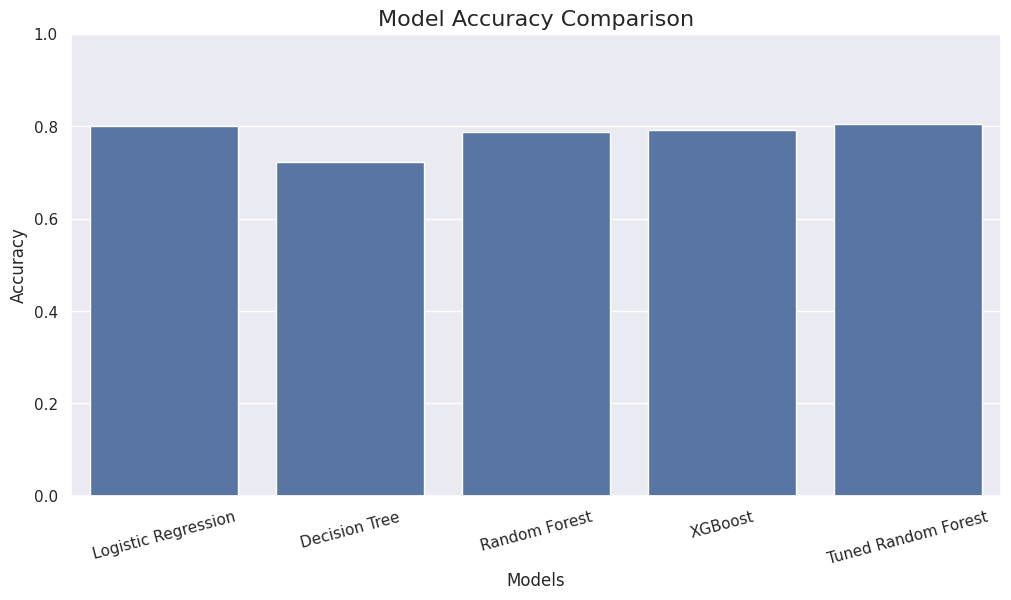

In [20]:
plt.figure(figsize=(12, 6))
accuracies = [results[model]['Accuracy'] for model in results]
model_names = list(results.keys())
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.savefig(output_dir + 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

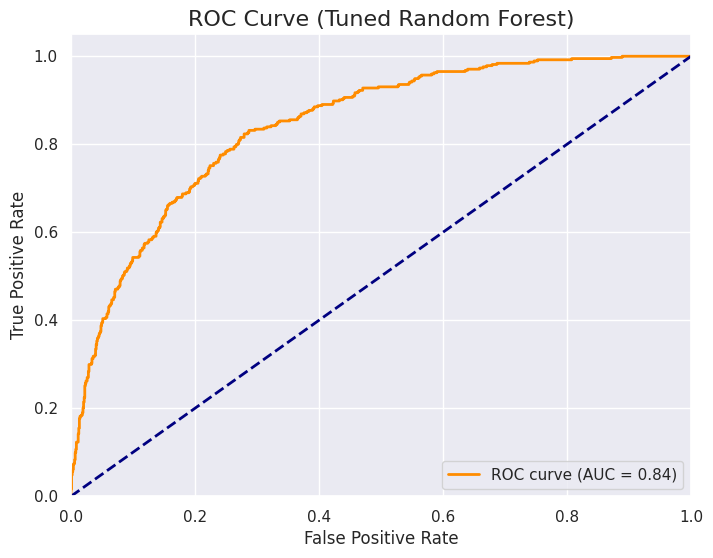

In [21]:
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (Tuned Random Forest)', fontsize=16)
plt.legend(loc="lower right")
plt.savefig(output_dir + 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

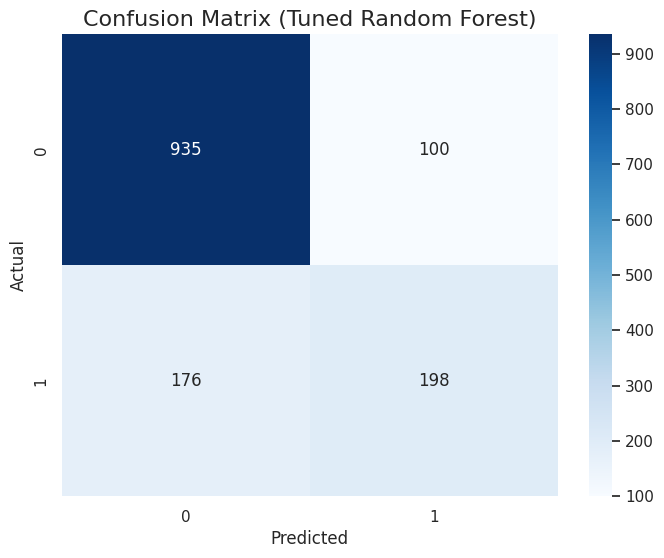

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(results['Tuned Random Forest']['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Tuned Random Forest)', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.savefig(output_dir + 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
def predict_churn(model, feature_names):
    """Predict churn based on user input with error handling."""
    print("\n=== Churn Prediction ===")
    print("Enter the following customer details (use 0/1 for Yes/No, or numeric values where applicable):")

    input_data = {}
    for feature in feature_names:
        while True:
            try:
                if feature in ['tenure', 'MonthlyCharges', 'TotalCharges']:
                    value = float(input(f"{feature}: "))
                    if value < 0:  # Basic validation
                        raise ValueError("Value cannot be negative.")
                else:
                    value = int(input(f"{feature} (0 for No, 1 for Yes or Male, etc.): "))
                    if value not in [0, 1]:  # Binary check
                        raise ValueError("Enter 0 or 1 only.")
                input_data[feature] = value
                break
            except ValueError as e:
                print(f"Invalid input: {e}. Please try again.")

    # Create DataFrame from input
    input_df = pd.DataFrame([input_data], columns=feature_names)

    # Predict using the model
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]

    # Display result
    churn_result = "Yes" if prediction == 1 else "No"
    print(f"\nPrediction: Customer will churn? {churn_result}")
    print(f"Churn Probability: {probability:.2%}")

predict_churn(best_rf, X.columns)


=== Churn Prediction ===
Enter the following customer details (use 0/1 for Yes/No, or numeric values where applicable):
gender (0 for No, 1 for Yes or Male, etc.): 1
SeniorCitizen (0 for No, 1 for Yes or Male, etc.): 0
Partner (0 for No, 1 for Yes or Male, etc.): 0
Dependents (0 for No, 1 for Yes or Male, etc.): 0
tenure: 2
PhoneService (0 for No, 1 for Yes or Male, etc.): 0
MultipleLines (0 for No, 1 for Yes or Male, etc.): 1
InternetService (0 for No, 1 for Yes or Male, etc.): 1
OnlineSecurity (0 for No, 1 for Yes or Male, etc.): 1
OnlineBackup (0 for No, 1 for Yes or Male, etc.): 1
DeviceProtection (0 for No, 1 for Yes or Male, etc.): 0
TechSupport (0 for No, 1 for Yes or Male, etc.): 0
StreamingTV (0 for No, 1 for Yes or Male, etc.): 0
StreamingMovies (0 for No, 1 for Yes or Male, etc.): 1
Contract (0 for No, 1 for Yes or Male, etc.): 0
PaperlessBilling (0 for No, 1 for Yes or Male, etc.): 1
PaymentMethod (0 for No, 1 for Yes or Male, etc.): 0
MonthlyCharges: 3500
TotalCharges: 20

In [24]:
print("\n=== Downloading Output Files ===")
for file in ['churn_distribution.png', 'model_comparison.png', 'roc_curve.png', 'feature_importance.png', 'confusion_matrix.png']:
    files.download(output_dir + file)


=== Downloading Output Files ===


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: /content/drive/My Drive/Churn_Prediction_Output/feature_importance.png